In [662]:
import cv2
import glob
import numpy as np
from torch.autograd import Variable
import torch.nn as nn

In [663]:
imgs_names = []
target_names = []

In [664]:
# Here we get the names of all the pictures that we are going to be using
for filename in glob.glob('../Research/Shadow/card/train/*.png'):
    imgs_names.append(filename)
    s = ""
    s += filename[0:24] + "gt/" + filename[31:len(filename)]
    target_names.append(s)

In [665]:
imgs = []
target = []

# Loop that read in the images and the target images
for i in range(0, len(imgs_names)):
    imgs.append(cv2.imread(imgs_names[i]))
    target.append(cv2.imread(target_names[i]))

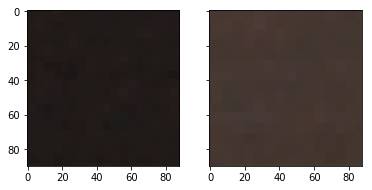

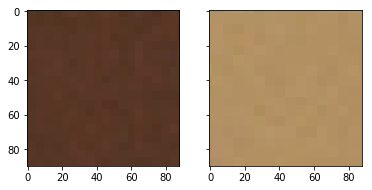

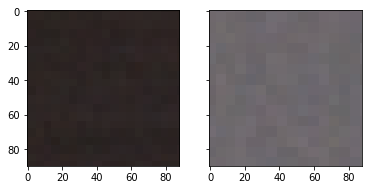

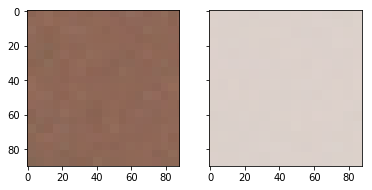

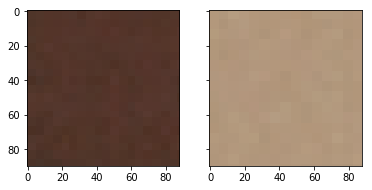

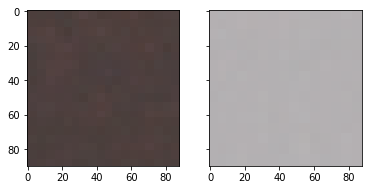

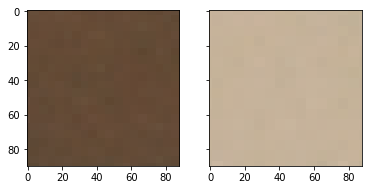

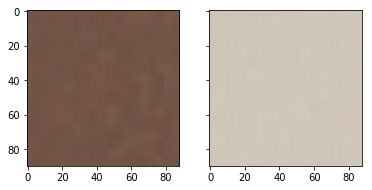

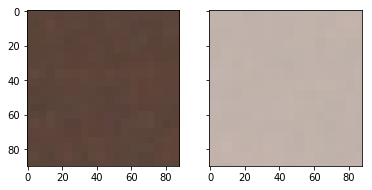

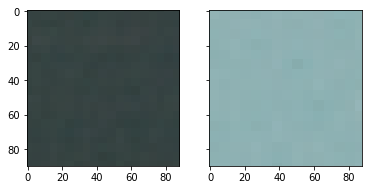

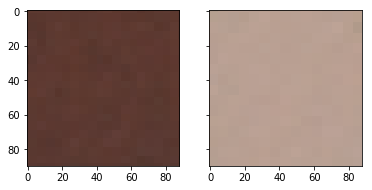

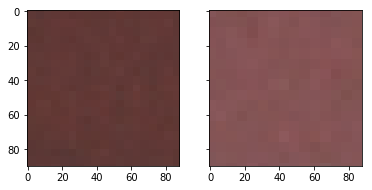

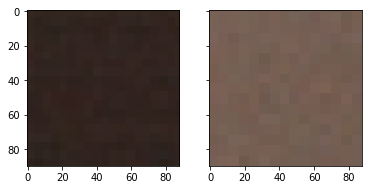

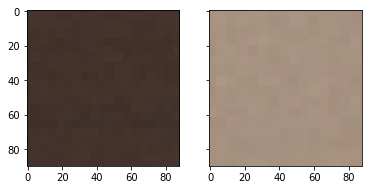

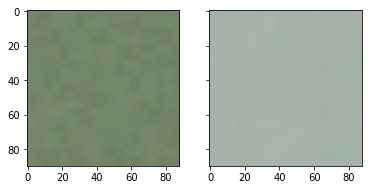

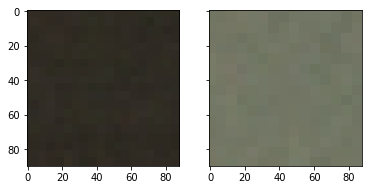

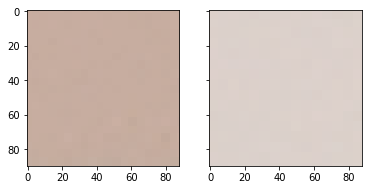

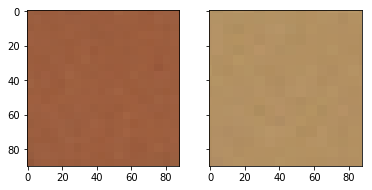

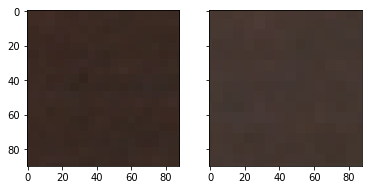

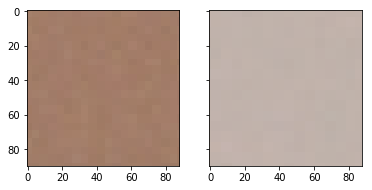

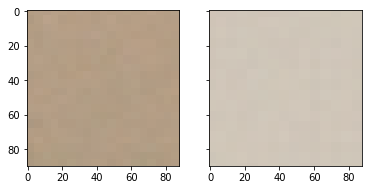

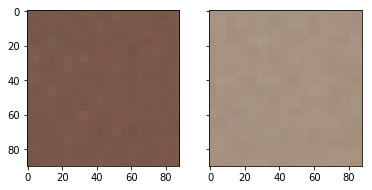

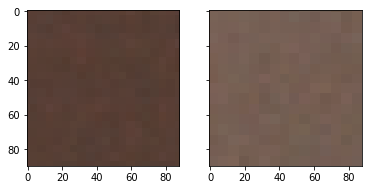

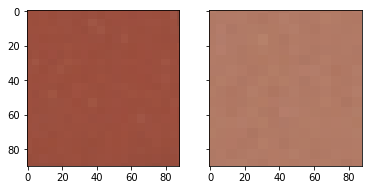

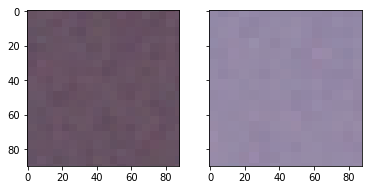

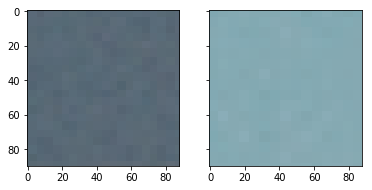

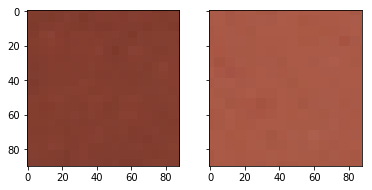

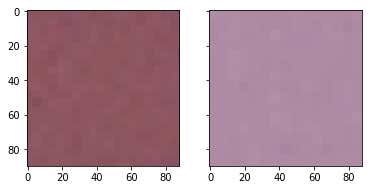

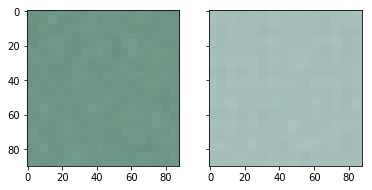

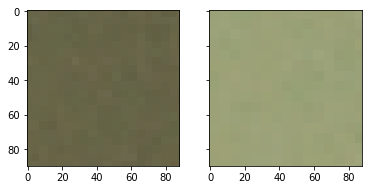

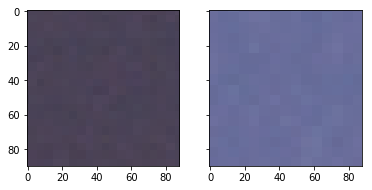

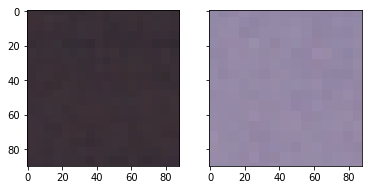

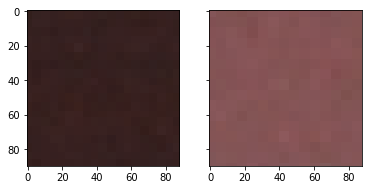

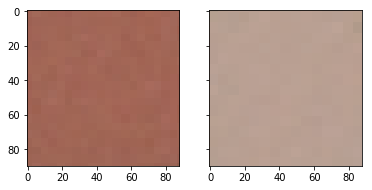

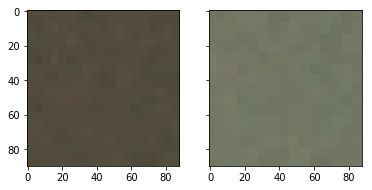

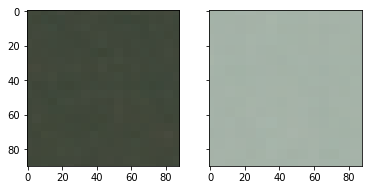

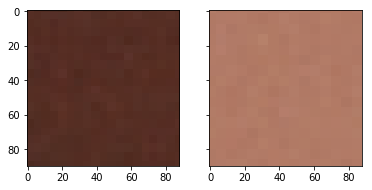

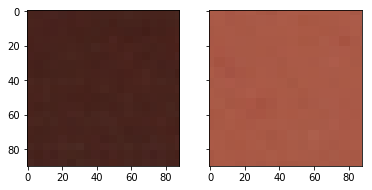

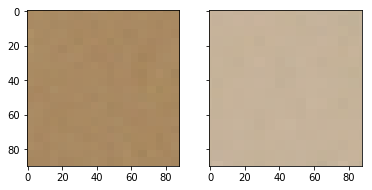

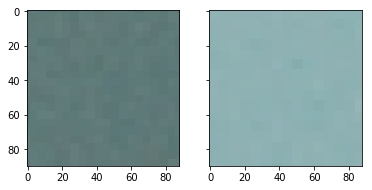

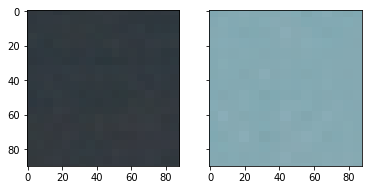

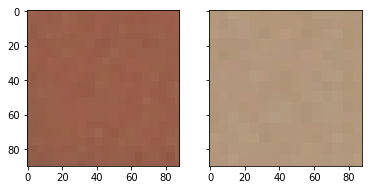

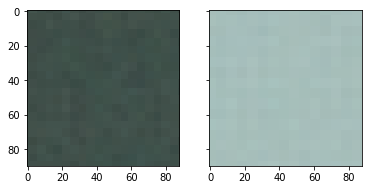

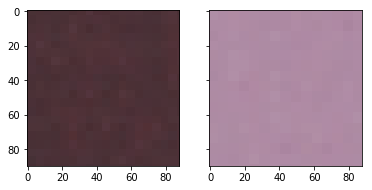

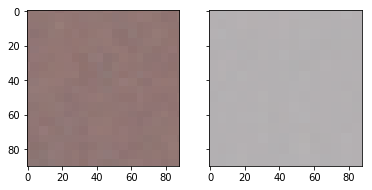

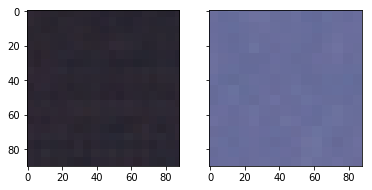

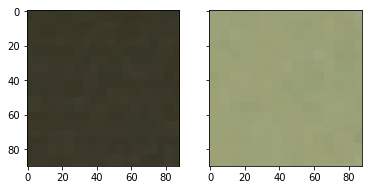

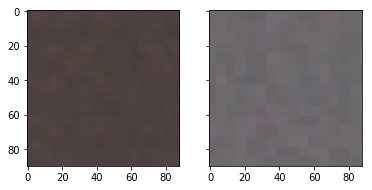

In [666]:
import matplotlib.pyplot as plt

# This output the images that are being used and generated
# First column is for the training image (original)
# Third column is the target values (gt)
for i in range(48):
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
    for j in range(3):
        if j == 0:
            ax[j].imshow(imgs[i])
        elif j == 1:
            ax[j].imshow(target[i])


In [667]:
import torch
# converting the lists into numpy arrays
n_imgs = np.asarray(imgs)/255
n_target = np.asarray(target)/255

# convert the numpy arrays into torch tensors
t_imgs = torch.tensor(np.asarray(n_imgs).reshape(-1, 3)) # this is to do regression on channels
t_target = torch.tensor(np.asarray(n_target).reshape(-1, 3)) # this is to do regression on channels

In [668]:
# Check the sizes of the images
print(t_imgs.size(), t_target.size())
print(n_imgs.shape, n_target.shape)

torch.Size([380160, 3]) torch.Size([380160, 3])
(48, 90, 88, 3) (48, 90, 88, 3)


In [669]:
from torch.utils.data import Dataset, DataLoader

# Create the data class, this is done to load the data into the pytorch model
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = t_imgs.view(-1, 3).float()
        self.y = t_target.float()
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get items
    def __len__(self):
        return self.len

In [670]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.linear(x)
        return self.relu(out)

class SimpleNet(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(SimpleNet, self).__init__()
        
        self.i = nn.Linear(inputSize, 32)
        self.relu1 = nn.ReLU() 
        
        self.h2 = nn.Linear(32, 64)
        self.relu2 = nn.ReLU() 
        
        self.h3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU() 
        
        self.o = nn.Linear(32, outputSize)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        
        output1 = self.i(x)
        output1 = self.relu1(output1)

        output2 = self.h2(output1)
        output2 = self.relu2(output2)

        output3 = self.h3(output2)
        output3 = self.relu3(output3)
        
        output4 = output1 + output3 # skip connection
        
        output = self.o(output4)
#         output = self.relu4(output)
        
        return output

In [671]:
trainloader = DataLoader(dataset=Data(), batch_size=32) # Create the loader for the model 
model = SimpleNet(3, 3) # Initialize the model

In [672]:
# This method is to save the model after a threshold
def save_models(epoch):
    torch.save(model.state_dict(), "reg_model{}.model".format(epoch))
    print("Chekcpoint saved")

In [673]:
# Hyperparameters
learningRate = 1
epochs = 10

In [674]:
criterion = torch.nn.MSELoss() # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate) # Gradient

In [675]:
# Train the model
def train_model(epochs):
    for epoch in range(epochs):  
        for x, y in trainloader:
#             print(x.shape, y.shape)
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             print(yhat[0], y[0])
            
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        if epoch % 10 ==0:
            save_models(epoch)

train_model(10)

epoch 0, loss 9.522868640488014e-05
Chekcpoint saved
epoch 1, loss 9.973759006243199e-05
epoch 2, loss 0.00010167704749619588
epoch 3, loss 0.00010307714546797797
epoch 4, loss 0.00010276636021444574
epoch 5, loss 0.0001020581039483659
epoch 6, loss 0.00010226389713352546
epoch 7, loss 0.00010108681453857571
epoch 8, loss 0.00010080376523546875
epoch 9, loss 0.00010251156345475465


In [676]:
with torch.no_grad():
    predicted = model(t_imgs.float()).data.numpy()
    org = t_imgs.numpy()
    res = t_target.numpy()


In [677]:
type(t_target.numpy())

numpy.ndarray

In [678]:
predicted = predicted.reshape(48, 90, 88, 3)
org = org.reshape(48, 90, 88, 3)
res = res.reshape(48, 90, 88, 3)

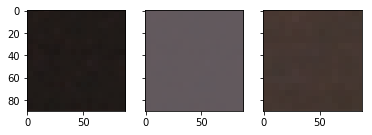

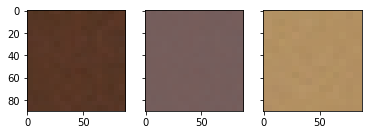

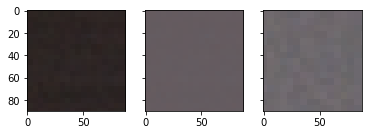

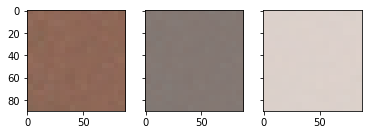

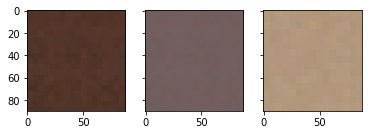

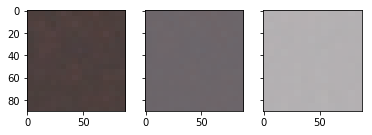

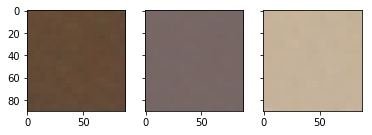

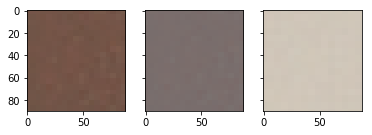

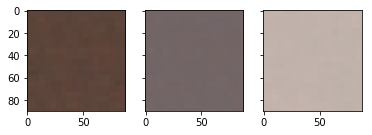

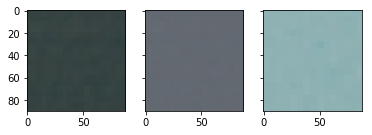

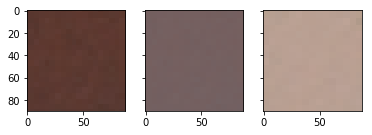

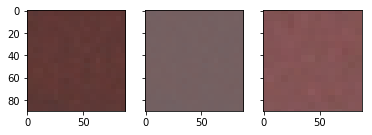

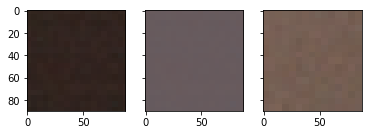

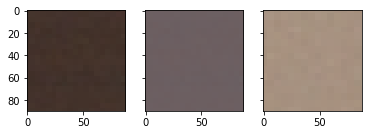

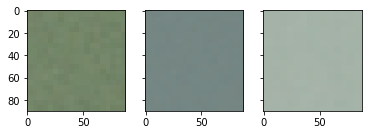

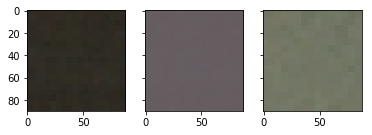

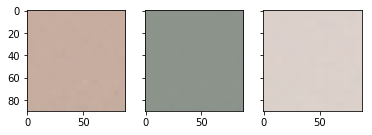

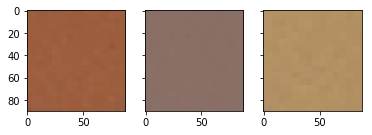

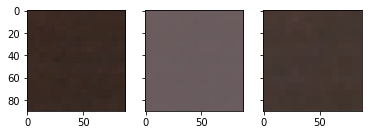

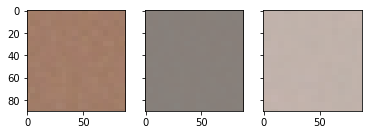

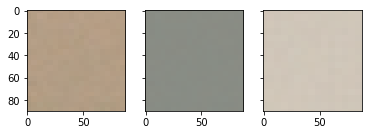

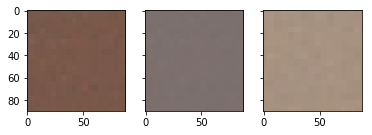

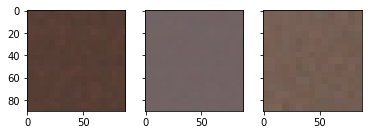

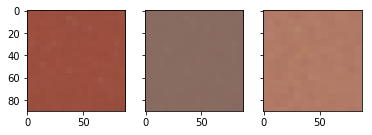

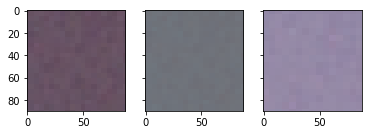

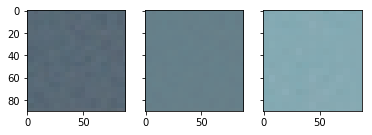

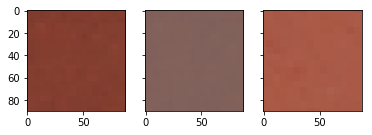

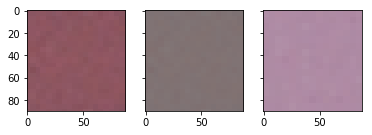

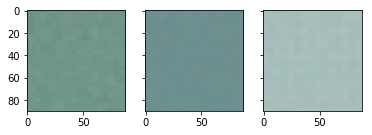

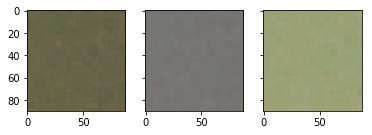

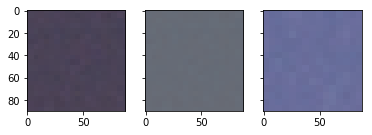

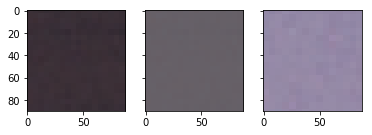

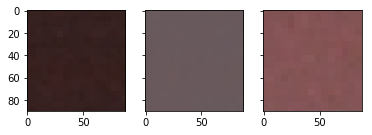

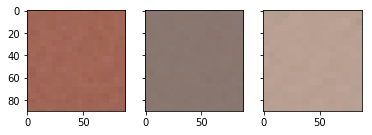

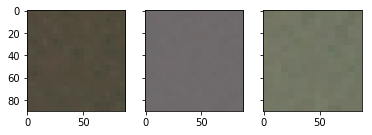

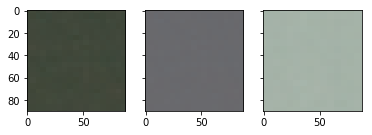

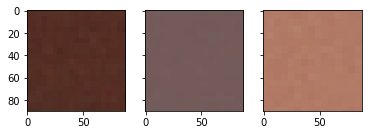

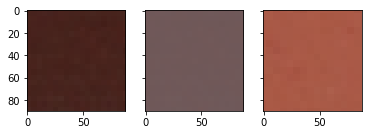

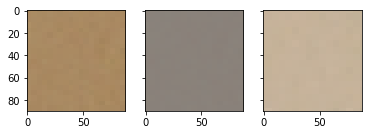

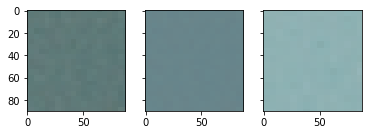

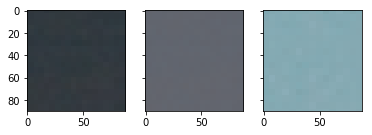

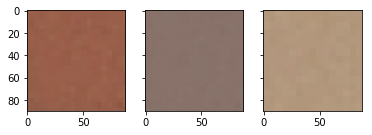

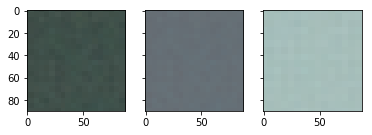

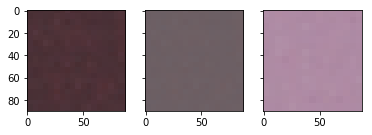

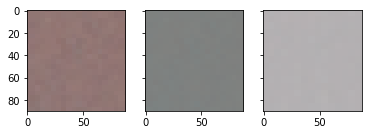

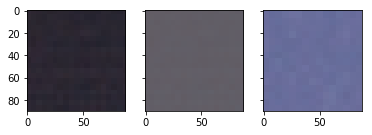

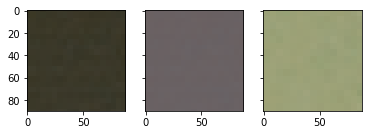

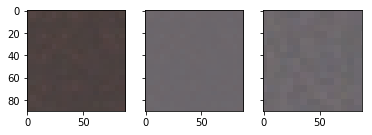

In [679]:
# This output the images that are being used and generated
# First column is for the training image (original)
# Second column is for the prediction (generated)
# Third column is the target values (gt)
for i in range(48):
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    for j in range(3):
        if j == 0:
            ax[j].imshow(org[i])
        elif j == 1:
            ax[j].imshow(predicted[i])
        elif j == 2:
            ax[j].imshow(res[i])


(1200, 1920, 3)


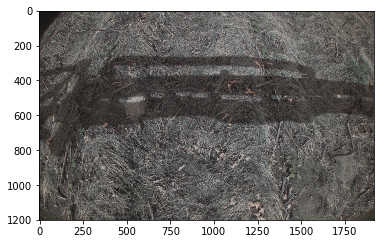

In [680]:
im = cv2.imread('../Research/Shadow/shadow.png')

plt.figure(0)
plt.imshow(im)
print(im.shape)

im = im/255
t_im = torch.tensor(np.asarray(im).reshape(-1, 3)) # this is to do regression on channels

In [681]:
with torch.no_grad():
    predicted = model(t_im.float()).data.numpy()
predicted = predicted.reshape(1200, 1920, 3)

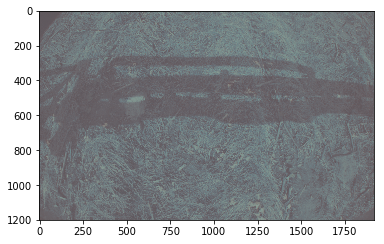

In [683]:
plt.figure(0)
# plt.imshow((predicted * 255).astype(np.uint8))
plt.imshow(predicted)
    
plt.show()